# Time Series Segmentation with sktime and ClaSP

In this notebook, we will showcase `sktime` and `ClaSP` for the task of time series segmentation. We will first give an introduction to the task of time series segmentation, illustrate the ease of use of ClaSP, and present the found segmentation for a show case.

# The Task of Time Series Segmentation

A particularly interesting problem which we will study in this notebook is time series segmentation (TSS). 

TSS aims at discovering regions of a time series that are semantically dissimilar to neighboring regions. TSS is an important technology, as it allows to infer properties of the underlying system by analysis of the measurements, because shifts from one segment to another are often caused by state changes in the process being monitored, such as a transition from one operational state to another or the onset of an unusual event. Change point detection (CPD) is the task of finding such shifts in the underlying signal, and a segmentation is an ordered sequence of change points. 

The following image shows two examples of (a) heartbeats recorded from a patient with different medical conditions, and (b) a person walking, jogging and running. The time series contain three visually very distinct segments, which we also denoted by colors and annotated by the underlying state.
<img src="./img/segmentation_use_cases.png" width="400" alt="use-cases">

The task of any TSS algorithm is to find these segments.

# Prerequisites

In [1]:
import sys

sys.path.insert(0, "..")

import pandas as pd
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes
from sktime.annotation.plotting.utils import (
    plot_time_series_with_change_points,
    plot_time_series_with_profiles,
)
from sktime.datasets import load_electric_devices_segmentation

The following use case shows an energy profile of electric household devices with four change points indicating different operational states or pluged household devices.

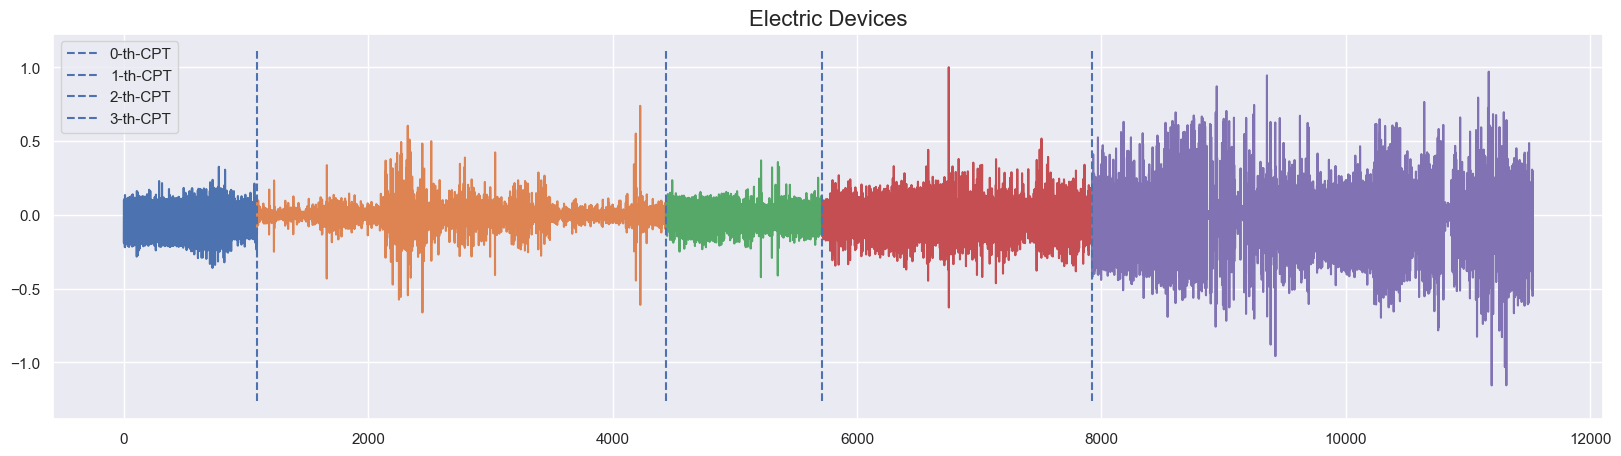

In [2]:
ts, period_size, true_cps = load_electric_devices_segmentation()
_ = plot_time_series_with_change_points("Electric Devices", ts, true_cps)

The anotated change points are around time stamps $[1090,4436,5712,7923]$, from which different electric devices are recorded.

# Time Series Segmentation through ClaSP

This Jupyter-Notebook illustrates the usage of the *Classification Score Profile (ClaSP)* for time series segmentation. 

ClaSP hierarchically splits a TS into two parts, where each split point is determined by training a binary TS classifier for each possible split point and selecting the one with highest accuracy, i.e., the one that is best at identifying subsequences to be from either of the partitions. 

Please refer to our paper, published at CIKM '21, for details:
*P. Schäfer, A. Ermshaus, U. Leser, ClaSP - Time Series Segmentation, CIKM 2021*

# Retrieve the data

First lets look at and plot the time series to be segmented.

In [3]:
# ts is a pd.Series
# we convert it into a DataFrame for display purposed only
pd.DataFrame(ts)

,1
1,-0.187086
2,0.098119
3,0.088967
4,0.107328
5,-0.193514
...,...
11528,0.300240
11529,0.200745
11530,-0.548908
11531,0.274886


# ClaSP - Classification Score Profile

Let's run ClaSP to find the true change point. 

ClaSP has two hyper-parameters:
- The period length
- The number of change points to find

The result of ClaSP is a profile in which the maximum indicates the found change points.

In [4]:
clasp = ClaSPSegmentation(period_length=period_size, n_cps=5, fmt="sparse")
found_cps = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores
print("The found change points are", found_cps.to_numpy())

The found change points are [1038 4525 5719 7883]


# Visualization of segmentation
... and we visualize the results.

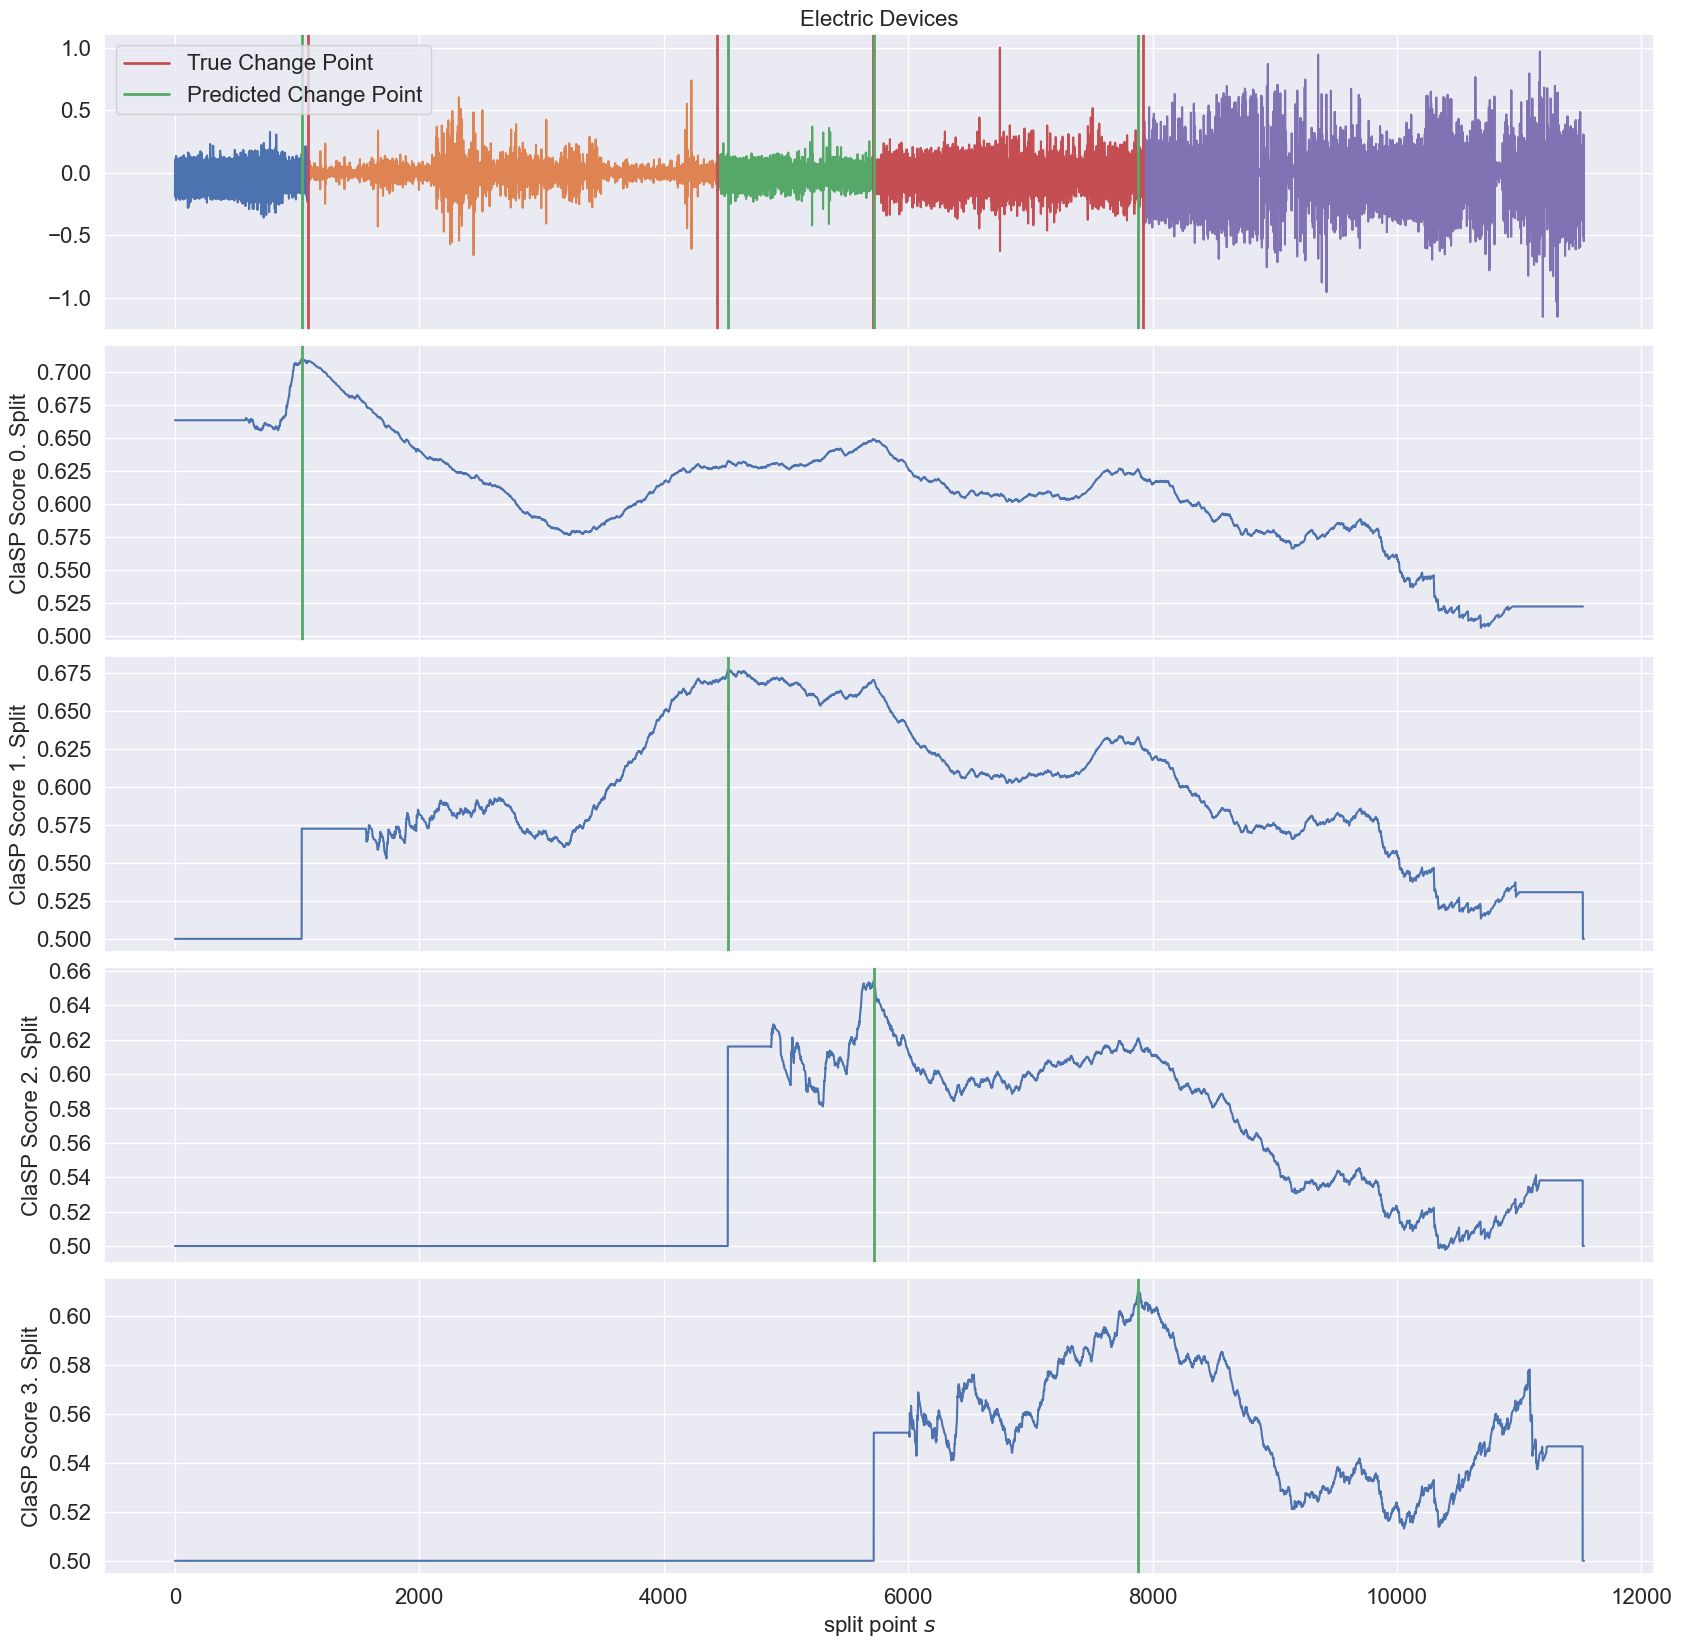

In [6]:
_ = plot_time_series_with_profiles(
    "Electric Devices",
    ts,
    profiles,
    true_cps,
    found_cps,
)

The predicted change points in green closely resembles the true change points in red.

# Output formats

ClaSP provides two different output formats given the `fmt` input parameter:
- `fmt:"sparse"`: provides the core change points
- `fmt:"dense"`: provides an inteval series giving the segmentation

We have seen the output of `fmt="sparse"` before. This time we return `fmt="dense"`.

In [7]:
clasp = ClaSPSegmentation(period_length=period_size, n_cps=5, fmt="dense")
found_segmentation = clasp.fit_predict(ts)
print(found_segmentation)

IntervalIndex([(0, 1038], (1038, 4525], (4525, 5719], (5719, 7883], (7883, 11532]], dtype='interval[int64, right]')


# ClaSP - Window Size Selection

ClaSP takes the window size 𝑤 as a hyper-parameter. This parameter has data-dependent effects on ClaSP's performance. When chosen too small, all windows tend to appear similar; when chosen too large, windows have a higher chance to overlap adjacent segments, blurring their discriminative power. 

A simple, yet effective method for choosing the window size is the dominant frequency of the Fourier Transform.

In [8]:
dominant_period_size = find_dominant_window_sizes(ts)
print("Dominant Period", dominant_period_size)

Dominant Period 10


Let us run ClaSP with the found dominant period length.

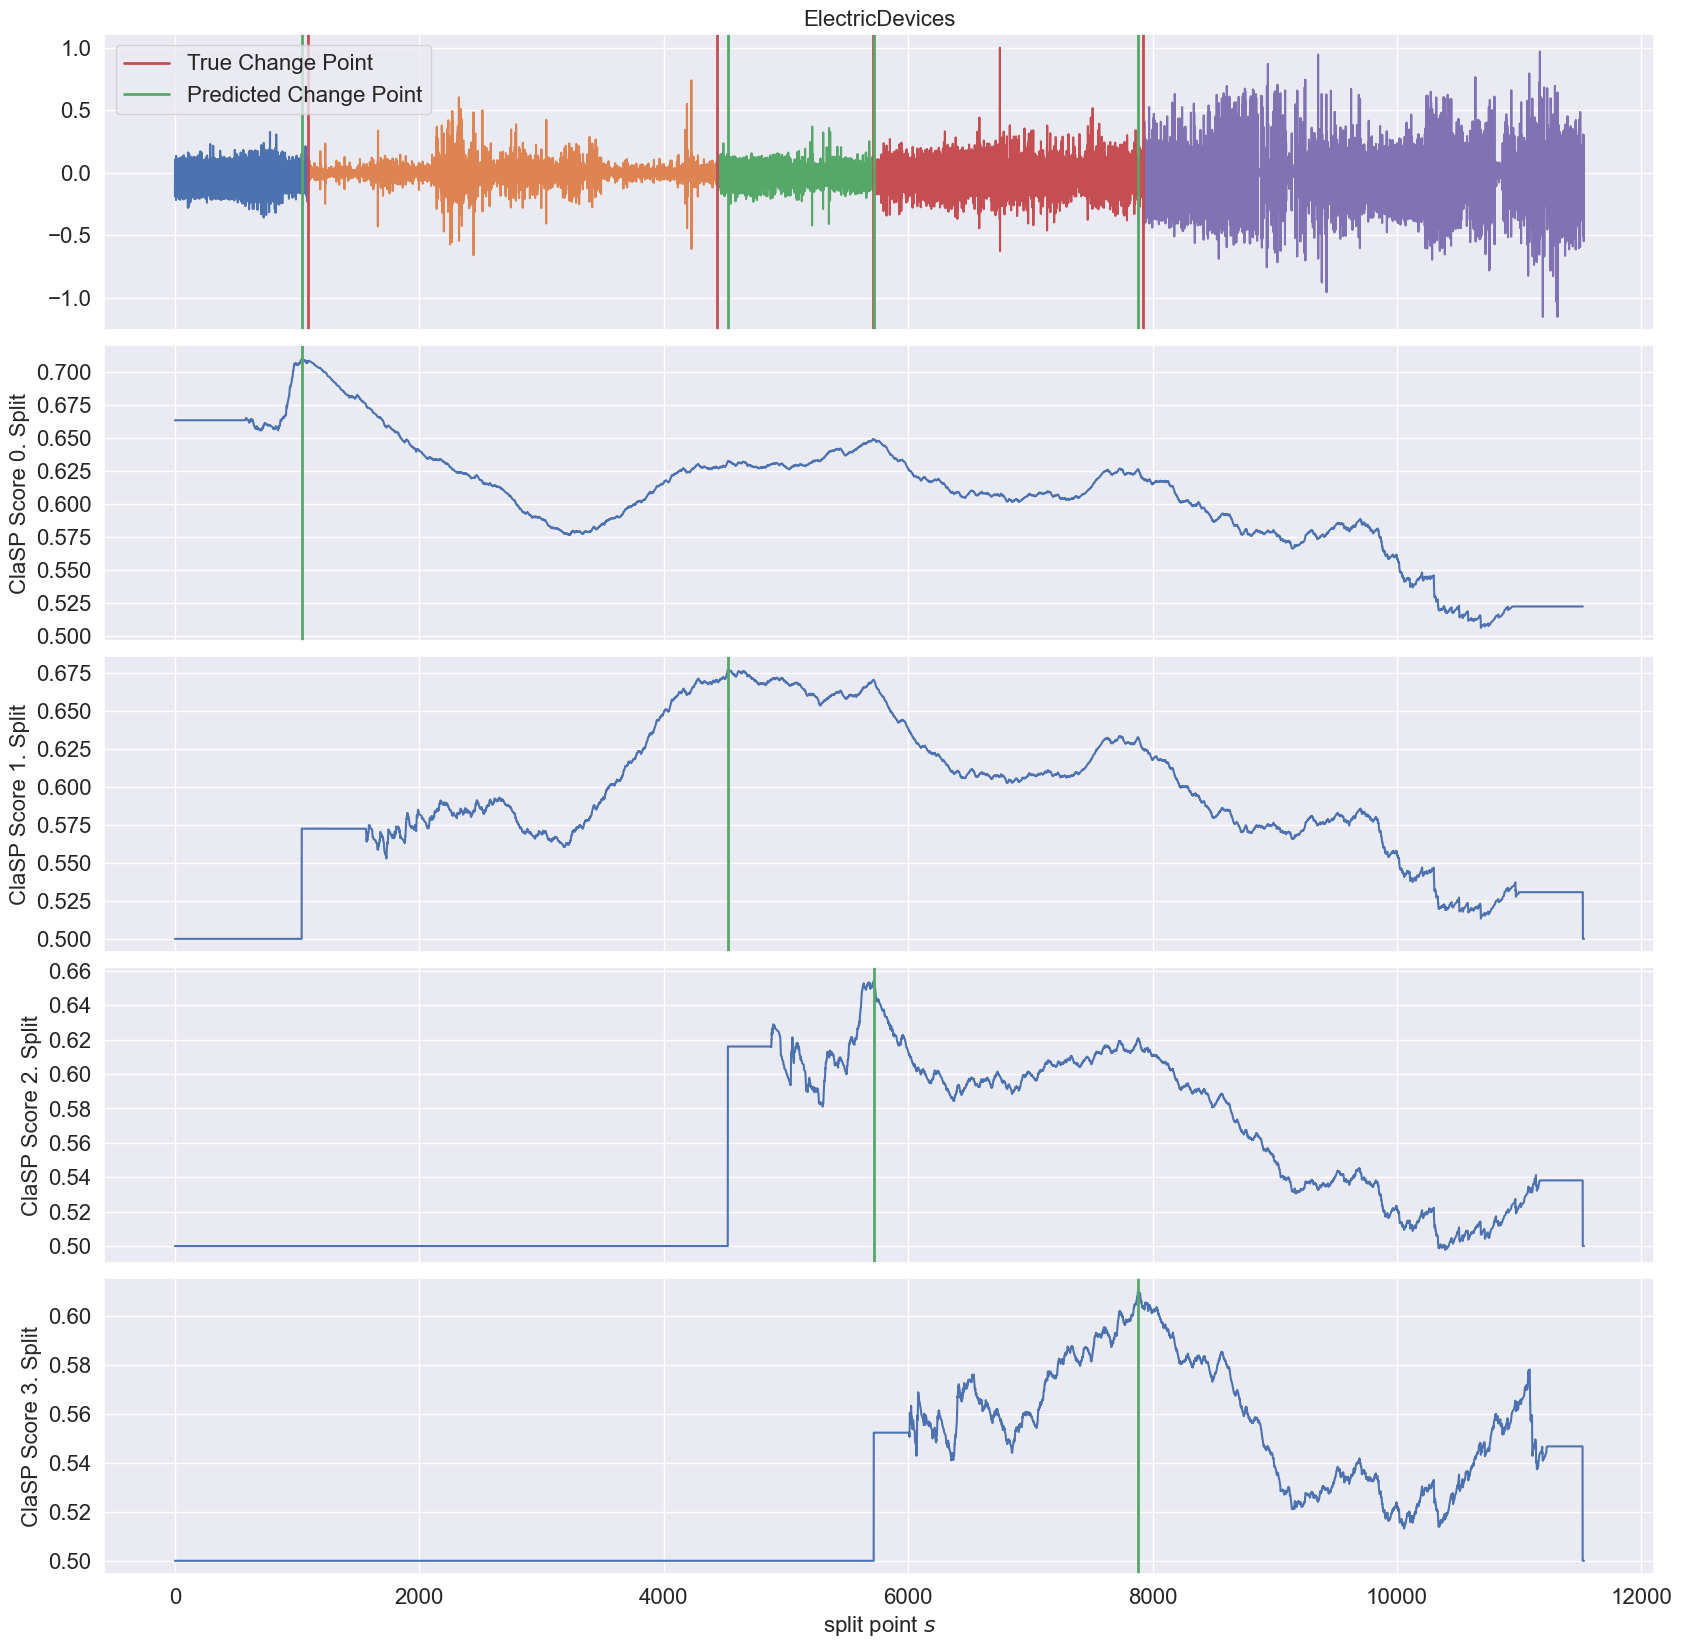

In [9]:
clasp = ClaSPSegmentation(period_length=dominant_period_size, n_cps=5)
found_cps = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores

_ = plot_time_series_with_profiles(
    "ElectricDevices",
    ts,
    profiles,
    true_cps,
    found_cps,
)